# Category identification of beers

#### Objective: build a beer classification model predicting if a beer is an "American IPA" or not based on its properties.

In [1]:
# import spark
from pyspark import SparkContext
# initialize a new Spark Context to use for the execution of the script
sc = SparkContext(appName="MY-APP-NAME", master="local[*]")
# prevent useless logging messages
sc.setLogLevel("ERROR")

from pyspark.sql.session import SparkSession

spark = SparkSession(sc)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.feature import HashingTF, StandardScaler
from pyspark.mllib.feature import LabeledPoint
from pyspark.ml.classification import LogisticRegression 
from pyspark.mllib.stat import Statistics

#### Data exploration and Manipulation Using Spark DataFrame

In [3]:
recipe_df = spark.read.csv(path="recipeData.csv", header=True)

In [4]:
# Guardo i primi 5 record
recipe_df.head(2)

[Row(BeerID='1', Name='Vanilla Cream Ale', URL='/homebrew/recipe/view/1633/vanilla-cream-ale', Style='Cream Ale', StyleID='45', Size(L)='21.77', OG='1.055', FG='1.013', ABV='5.48', IBU='17.65', Color='4.83', BoilSize='28.39', BoilTime='75', BoilGravity='1.038', Efficiency='70', MashThickness='N/A', SugarScale='Specific Gravity', BrewMethod='All Grain', PitchRate='N/A', PrimaryTemp='17.78', PrimingMethod='corn sugar', PrimingAmount='4.5 oz', UserId='116'),
 Row(BeerID='2', Name='Southern Tier Pumking clone', URL='/homebrew/recipe/view/16367/southern-tier-pumking-clone', Style='Holiday/Winter Special Spiced Beer', StyleID='85', Size(L)='20.82', OG='1.083', FG='1.021', ABV='8.16', IBU='60.65', Color='15.64', BoilSize='24.61', BoilTime='60', BoilGravity='1.07', Efficiency='70', MashThickness='N/A', SugarScale='Specific Gravity', BrewMethod='All Grain', PitchRate='N/A', PrimaryTemp='N/A', PrimingMethod='N/A', PrimingAmount='N/A', UserId='955')]

In [6]:
recipe_df.columns

['BeerID',
 'Name',
 'URL',
 'Style',
 'StyleID',
 'Size(L)',
 'OG',
 'FG',
 'ABV',
 'IBU',
 'Color',
 'BoilSize',
 'BoilTime',
 'BoilGravity',
 'Efficiency',
 'MashThickness',
 'SugarScale',
 'BrewMethod',
 'PitchRate',
 'PrimaryTemp',
 'PrimingMethod',
 'PrimingAmount',
 'UserId']

In [7]:
# Controllo il numero di record nell'rdd
recipe_df.count()

73861

Analizziamo la presenza di missing value:

In [8]:
for col in recipe_df.columns:
    print("{}: {}".format(col, recipe_df.filter(recipe_df[col] == 'N/A').count()))

BeerID: 0
Name: 1
URL: 0
Style: 596
StyleID: 0
Size(L): 0
OG: 0
FG: 0
ABV: 0
IBU: 0
Color: 0
BoilSize: 0
BoilTime: 0
BoilGravity: 2990
Efficiency: 0
MashThickness: 29864
SugarScale: 0
BrewMethod: 0
PitchRate: 39252
PrimaryTemp: 22662
PrimingMethod: 67094
PrimingAmount: 69084
UserId: 0


Eliminiamo le colonne PrimingMethod, PrimingAmount, PitchRate perché sono per lo più nulle. Eliminiamo anche Name, URL, UserId e Style (abbiamo il codice corrispondente nello StyleId) perché non sono utili per la nostra analisi.

In [9]:
recipe_df = recipe_df.drop('PitchRate', 'Name', 'URL', 'UserId', 'Style', 'PrimingMethod', 'PrimingAmount')

In [10]:
recipe_df.take(2)

[Row(BeerID='1', StyleID='45', Size(L)='21.77', OG='1.055', FG='1.013', ABV='5.48', IBU='17.65', Color='4.83', BoilSize='28.39', BoilTime='75', BoilGravity='1.038', Efficiency='70', MashThickness='N/A', SugarScale='Specific Gravity', BrewMethod='All Grain', PrimaryTemp='17.78'),
 Row(BeerID='2', StyleID='85', Size(L)='20.82', OG='1.083', FG='1.021', ABV='8.16', IBU='60.65', Color='15.64', BoilSize='24.61', BoilTime='60', BoilGravity='1.07', Efficiency='70', MashThickness='N/A', SugarScale='Specific Gravity', BrewMethod='All Grain', PrimaryTemp='N/A')]

Analizziamo la correlazione tra le variabili continue; creiamo prima un nuovo rdd con le variabili continue da cui filtro i valori N/A.

In [11]:
continuos_df = recipe_df.drop('SugarScale', 'BrewMethod').filter(recipe_df['BoilGravity'] != 'N/A').filter(recipe_df['MashThickness'] != 'N/A').filter(recipe_df['PrimaryTemp'] != 'N/A')

correlation_matrix = Statistics.corr(continuos_df.rdd.map(list), method="pearson")

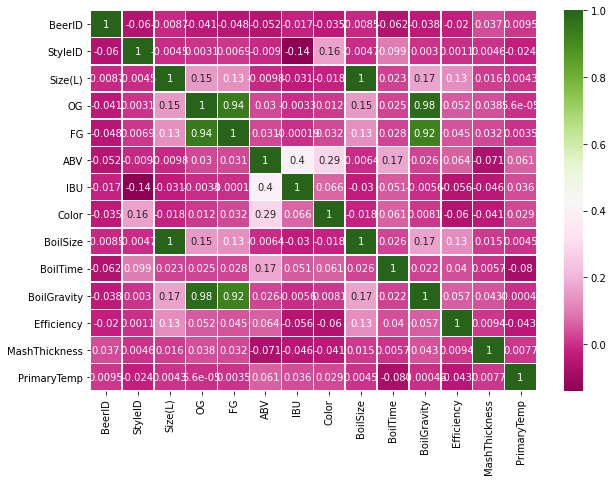

In [12]:
plt.figure(figsize=(10,7))
ax = sns.heatmap(correlation_matrix, linewidth=0.5, annot=True, cmap='PiYG', xticklabels=continuos_df.columns, yticklabels=continuos_df.columns)
plt.show()

C'è un forte correlazione tra Size e BoilSize, BoilGravity e OG (e FG), quindi rimuoviamo BoilSize, BoilGravity e FG

In [13]:
recipe_df = recipe_df.drop('BoilSize', 'BoilGravity', 'FG')

Ora vogliamo fillare i missing value per MashThickness e PrimaryTemp.

In [14]:
recipe_df.describe('MashThickness', 'PrimaryTemp').show()

+-------+------------------+------------------+
|summary|     MashThickness|       PrimaryTemp|
+-------+------------------+------------------+
|  count|             73861|             73861|
|   mean|2.1272352339932374|19.175640539853926|
| stddev| 1.682347279063247| 4.219675604693554|
|    min|                 0|             -0.56|
|    max|               N/A|               N/A|
+-------+------------------+------------------+



In [15]:
recipe_rdd = recipe_df.rdd.map(list)

In [16]:
MashThickness_rdd = recipe_rdd.filter(lambda x: x[9] != 'N/A').map(lambda x: float(x[9]))

In [17]:
mash_array = MashThickness_rdd.collect()

In [18]:
from scipy import stats

print("mean: ", np.mean(mash_array))
print("median: ", np.median(mash_array))
print("min: ", np.min(mash_array))
print("max: ", np.max(mash_array))
print("var: ", np.var(mash_array))
print("std: ", np.std(mash_array))
print("mode: ", stats.mode(mash_array)[0])

mean:  2.127235233993227
median:  1.5
min:  0.0
max:  100.0
var:  2.830228038158904
std:  1.6823281600683333
mode:  [1.5]


In [19]:
PrimaryTemp_rdd = recipe_rdd.filter(lambda x: x[12] != 'N/A').map(lambda x: float(x[12]))

In [20]:
prim_array = PrimaryTemp_rdd.collect()

In [21]:
print("mean: ", np.mean(prim_array))
print("median: ", np.median(prim_array))
print("min: ", np.min(prim_array))
print("max: ", np.max(prim_array))
print("var: ", np.var(prim_array))
print("std: ", np.std(prim_array))
print("mode: ", stats.mode(prim_array)[0])

mean:  19.175640539854292
median:  20.0
min:  -17.78
max:  114.0
var:  17.805314435213493
std:  4.219634395917908
mode:  [20.]


Fillo i valori di MashThickness e PrimaryTemp mancanti con la mediana che coincide con la moda. 

In [22]:
recipe_rdd = recipe_rdd.map(lambda x: x if x[9] != 'N/A' else x[:9] + [str(np.median(mash_array))] + x[10:])

In [23]:
recipe_rdd = recipe_rdd.map(lambda x: x if x[12] != 'N/A' else x[:12] + [str(np.median(prim_array))])

Ricreo lo spark dataframe

In [24]:
recipe_df1 = spark.createDataFrame(recipe_rdd, schema=recipe_df.columns)

In [25]:
recipe_df1.take(5)

[Row(BeerID='1', StyleID='45', Size(L)='21.77', OG='1.055', ABV='5.48', IBU='17.65', Color='4.83', BoilTime='75', Efficiency='70', MashThickness='1.5', SugarScale='Specific Gravity', BrewMethod='All Grain', PrimaryTemp='17.78'),
 Row(BeerID='2', StyleID='85', Size(L)='20.82', OG='1.083', ABV='8.16', IBU='60.65', Color='15.64', BoilTime='60', Efficiency='70', MashThickness='1.5', SugarScale='Specific Gravity', BrewMethod='All Grain', PrimaryTemp='20.0'),
 Row(BeerID='3', StyleID='7', Size(L)='18.93', OG='1.063', ABV='5.91', IBU='59.25', Color='8.98', BoilTime='60', Efficiency='70', MashThickness='1.5', SugarScale='Specific Gravity', BrewMethod='extract', PrimaryTemp='20.0'),
 Row(BeerID='4', StyleID='7', Size(L)='22.71', OG='1.061', ABV='5.8', IBU='54.48', Color='8.5', BoilTime='60', Efficiency='70', MashThickness='1.5', SugarScale='Specific Gravity', BrewMethod='All Grain', PrimaryTemp='20.0'),
 Row(BeerID='5', StyleID='20', Size(L)='50', OG='1.06', ABV='6.48', IBU='17.84', Color='4.57

Voglio trasformare le variabili categoriche SugarScale e BrewMethon in numeriche.

In [26]:
recipe_df1.groupBy("SugarScale").count().show()

+----------------+-----+
|      SugarScale|count|
+----------------+-----+
|           Plato| 1902|
|Specific Gravity|71959|
+----------------+-----+



In [27]:
recipe_df1.groupBy("BrewMethod").count().show()

+------------+-----+
|  BrewMethod|count|
+------------+-----+
|     extract| 8626|
|Partial Mash| 3527|
|   All Grain|49692|
|        BIAB|12016|
+------------+-----+



In [28]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

In [29]:
indexer = StringIndexer(inputCol="SugarScale", outputCol="SugarScaleIndex")
recipe_df1 = indexer.fit(recipe_df1).transform(recipe_df1)
recipe_df1.show(5)

+------+-------+-------+-----+----+-----+-----+--------+----------+-------------+----------------+----------+-----------+---------------+
|BeerID|StyleID|Size(L)|   OG| ABV|  IBU|Color|BoilTime|Efficiency|MashThickness|      SugarScale|BrewMethod|PrimaryTemp|SugarScaleIndex|
+------+-------+-------+-----+----+-----+-----+--------+----------+-------------+----------------+----------+-----------+---------------+
|     1|     45|  21.77|1.055|5.48|17.65| 4.83|      75|        70|          1.5|Specific Gravity| All Grain|      17.78|            0.0|
|     2|     85|  20.82|1.083|8.16|60.65|15.64|      60|        70|          1.5|Specific Gravity| All Grain|       20.0|            0.0|
|     3|      7|  18.93|1.063|5.91|59.25| 8.98|      60|        70|          1.5|Specific Gravity|   extract|       20.0|            0.0|
|     4|      7|  22.71|1.061| 5.8|54.48|  8.5|      60|        70|          1.5|Specific Gravity| All Grain|       20.0|            0.0|
|     5|     20|     50| 1.06|6.48

In [30]:
indexer = StringIndexer(inputCol="BrewMethod", outputCol="BrewMethodIndex")
recipe_df1 = indexer.fit(recipe_df1).transform(recipe_df1)

encoder = OneHotEncoder(inputCol="BrewMethodIndex", outputCol="BrewMethodVector")
recipe_df1 = encoder.transform(recipe_df1)
recipe_df1.show(5)

+------+-------+-------+-----+----+-----+-----+--------+----------+-------------+----------------+----------+-----------+---------------+---------------+----------------+
|BeerID|StyleID|Size(L)|   OG| ABV|  IBU|Color|BoilTime|Efficiency|MashThickness|      SugarScale|BrewMethod|PrimaryTemp|SugarScaleIndex|BrewMethodIndex|BrewMethodVector|
+------+-------+-------+-----+----+-----+-----+--------+----------+-------------+----------------+----------+-----------+---------------+---------------+----------------+
|     1|     45|  21.77|1.055|5.48|17.65| 4.83|      75|        70|          1.5|Specific Gravity| All Grain|      17.78|            0.0|            0.0|   (3,[0],[1.0])|
|     2|     85|  20.82|1.083|8.16|60.65|15.64|      60|        70|          1.5|Specific Gravity| All Grain|       20.0|            0.0|            0.0|   (3,[0],[1.0])|
|     3|      7|  18.93|1.063|5.91|59.25| 8.98|      60|        70|          1.5|Specific Gravity|   extract|       20.0|            0.0|        

In [31]:
recipe_df1 = recipe_df1.drop('BrewMethod', 'SugarScale', 'BrewMethodIndex')

In [32]:
recipe_df1.take(2)

[Row(BeerID='1', StyleID='45', Size(L)='21.77', OG='1.055', ABV='5.48', IBU='17.65', Color='4.83', BoilTime='75', Efficiency='70', MashThickness='1.5', PrimaryTemp='17.78', SugarScaleIndex=0.0, BrewMethodVector=SparseVector(3, {0: 1.0})),
 Row(BeerID='2', StyleID='85', Size(L)='20.82', OG='1.083', ABV='8.16', IBU='60.65', Color='15.64', BoilTime='60', Efficiency='70', MashThickness='1.5', PrimaryTemp='20.0', SugarScaleIndex=0.0, BrewMethodVector=SparseVector(3, {0: 1.0}))]

Aggiungiamo la colonna target da predirre isIPA: guardiamo lo style "American IPA" a che style id corrisponde nel file che contiene il mapping tra l'id numerico e il nome.

In [33]:
style_rdd = sc.textFile("styleData.csv")

In [34]:
style_rdd = style_rdd.map(lambda x: x.split(','))

In [35]:
style_rdd = style_rdd.keyBy(lambda x: x[0])

In [36]:
style_rdd.take(5)

[('Style', ['Style', 'StyleID']),
 ('Altbier', ['Altbier', '1']),
 ('Alternative Grain Beer', ['Alternative Grain Beer', '2']),
 ('Alternative Sugar Beer', ['Alternative Sugar Beer', '3']),
 ('American Amber Ale', ['American Amber Ale', '4'])]

In [37]:
style_rdd.lookup('American IPA')

[['American IPA', '7']]

Quindi lo StyleID che mi interessa è il 7

In [38]:
recipe_df1 = recipe_df1.withColumn('IsIPA', recipe_df1.StyleID=='7')
recipe_df1 = recipe_df1.drop('StyleID')

In [39]:
recipe_df1 = recipe_df1.select('IsIPA','*')

In [40]:
recipe_df1.take(5)

[Row(IsIPA=False, BeerID='1', Size(L)='21.77', OG='1.055', ABV='5.48', IBU='17.65', Color='4.83', BoilTime='75', Efficiency='70', MashThickness='1.5', PrimaryTemp='17.78', SugarScaleIndex=0.0, BrewMethodVector=SparseVector(3, {0: 1.0}), IsIPA=False),
 Row(IsIPA=False, BeerID='2', Size(L)='20.82', OG='1.083', ABV='8.16', IBU='60.65', Color='15.64', BoilTime='60', Efficiency='70', MashThickness='1.5', PrimaryTemp='20.0', SugarScaleIndex=0.0, BrewMethodVector=SparseVector(3, {0: 1.0}), IsIPA=False),
 Row(IsIPA=True, BeerID='3', Size(L)='18.93', OG='1.063', ABV='5.91', IBU='59.25', Color='8.98', BoilTime='60', Efficiency='70', MashThickness='1.5', PrimaryTemp='20.0', SugarScaleIndex=0.0, BrewMethodVector=SparseVector(3, {2: 1.0}), IsIPA=True),
 Row(IsIPA=True, BeerID='4', Size(L)='22.71', OG='1.061', ABV='5.8', IBU='54.48', Color='8.5', BoilTime='60', Efficiency='70', MashThickness='1.5', PrimaryTemp='20.0', SugarScaleIndex=0.0, BrewMethodVector=SparseVector(3, {0: 1.0}), IsIPA=True),
 Row

Ora creiamo il nostro rdd e labeled point per lavorare con gli algorimti di classificazione di MLLib

In [48]:
# Rimuoviamo l'id che non serve
recipe_df1 = recipe_df1.drop('BeerID')

In [49]:
#spark_df = spark.createDataFrame(df.drop(['StyleID','SugarScale', 'BrewMethod'], axis=1).astype(str))
data_rdd = recipe_df1.rdd

In [50]:
data_rdd.take(5)

[Row(IsIPA=False, Size(L)='21.77', OG='1.055', ABV='5.48', IBU='17.65', Color='4.83', BoilTime='75', Efficiency='70', MashThickness='1.5', PrimaryTemp='17.78', SugarScaleIndex=0.0, BrewMethodVector=SparseVector(3, {0: 1.0}), IsIPA=False),
 Row(IsIPA=False, Size(L)='20.82', OG='1.083', ABV='8.16', IBU='60.65', Color='15.64', BoilTime='60', Efficiency='70', MashThickness='1.5', PrimaryTemp='20.0', SugarScaleIndex=0.0, BrewMethodVector=SparseVector(3, {0: 1.0}), IsIPA=False),
 Row(IsIPA=True, Size(L)='18.93', OG='1.063', ABV='5.91', IBU='59.25', Color='8.98', BoilTime='60', Efficiency='70', MashThickness='1.5', PrimaryTemp='20.0', SugarScaleIndex=0.0, BrewMethodVector=SparseVector(3, {2: 1.0}), IsIPA=True),
 Row(IsIPA=True, Size(L)='22.71', OG='1.061', ABV='5.8', IBU='54.48', Color='8.5', BoilTime='60', Efficiency='70', MashThickness='1.5', PrimaryTemp='20.0', SugarScaleIndex=0.0, BrewMethodVector=SparseVector(3, {0: 1.0}), IsIPA=True),
 Row(IsIPA=False, Size(L)='50', OG='1.06', ABV='6.48

Converto lo sparse vector 

In [51]:
data_rdd = data_rdd.map(lambda x: list(x[:-2]) + list(x['BrewMethodVector'].toArray()))

In [52]:
data_rdd.take(2)

[[False,
  '21.77',
  '1.055',
  '5.48',
  '17.65',
  '4.83',
  '75',
  '70',
  '1.5',
  '17.78',
  0.0,
  1.0,
  0.0,
  0.0],
 [False,
  '20.82',
  '1.083',
  '8.16',
  '60.65',
  '15.64',
  '60',
  '70',
  '1.5',
  '20.0',
  0.0,
  1.0,
  0.0,
  0.0]]

Visualizziamo la densità delle variabili continue per le due classi

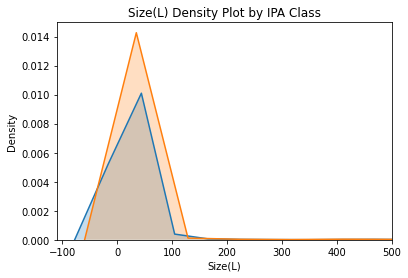

In [407]:
sns.kdeplot(data_rdd.filter(lambda x: x[0] == True).map(lambda x: x[2]).collect(), shade=True)
sns.kdeplot(data_rdd.filter(lambda x: x[0] == False).map(lambda x: x[2]).collect(), shade=True)
plt.title('Size(L) Density Plot by IPA Class')
plt.xlabel('Size(L)')
plt.ylabel('Density')
plt.xlim(-110,500)
plt.show()

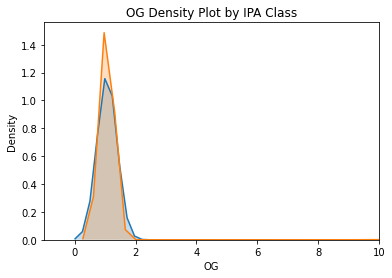

In [408]:
sns.kdeplot(data_rdd.filter(lambda x: x[0] == True).map(lambda x: x[3]).collect(), shade=True)
sns.kdeplot(data_rdd.filter(lambda x: x[0] == False).map(lambda x: x[3]).collect(), shade=True)
plt.title('OG Density Plot by IPA Class')
plt.xlabel('OG')
plt.ylabel('Density')
plt.xlim(-1,10)
plt.show()

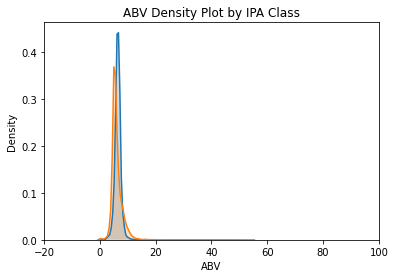

In [409]:
sns.kdeplot(data_rdd.filter(lambda x: x[0] == True).map(lambda x: x[4]).collect(), shade=True)
sns.kdeplot(data_rdd.filter(lambda x: x[0] == False).map(lambda x: x[4]).collect(), shade=True)
plt.title('ABV Density Plot by IPA Class')
plt.xlabel('ABV')
plt.ylabel('Density')
plt.xlim(-20,100)
plt.show()

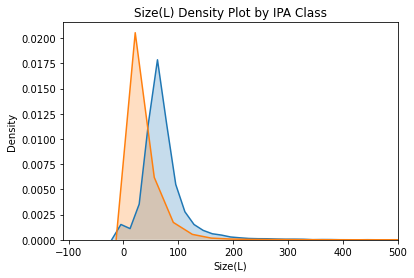

In [410]:
sns.kdeplot(data_rdd.filter(lambda x: x[0] == True).map(lambda x: x[5]).collect(), shade=True)
sns.kdeplot(data_rdd.filter(lambda x: x[0] == False).map(lambda x: x[5]).collect(), shade=True)
plt.title('Size(L) Density Plot by IPA Class')
plt.xlabel('Size(L)')
plt.ylabel('Density')
plt.xlim(-110,500)
plt.show()

In [53]:
data_rdd = data_rdd.map(lambda x: LabeledPoint(x[0], x[1:]))

In [54]:
data_rdd.take(5)

[LabeledPoint(0.0, [21.77,1.055,5.48,17.65,4.83,75.0,70.0,1.5,17.78,0.0,1.0,0.0,0.0]),
 LabeledPoint(0.0, [20.82,1.083,8.16,60.65,15.64,60.0,70.0,1.5,20.0,0.0,1.0,0.0,0.0]),
 LabeledPoint(1.0, [18.93,1.063,5.91,59.25,8.98,60.0,70.0,1.5,20.0,0.0,0.0,0.0,1.0]),
 LabeledPoint(1.0, [22.71,1.061,5.8,54.48,8.5,60.0,70.0,1.5,20.0,0.0,1.0,0.0,0.0]),
 LabeledPoint(0.0, [50.0,1.06,6.48,17.84,4.57,90.0,72.0,1.5,19.0,0.0,1.0,0.0,0.0])]

Ora splittiamo in test e train set e analizziamo la distribuzione della classe target.

In [55]:
train_rdd, test_rdd = data_rdd.randomSplit([0.7,0.3])

In [56]:
def count_labels(raw_rdd):
    return dict(
        raw_rdd
            .map(lambda x: ("IPA" if x.label == 1 else "No IPA", 1))
            .reduceByKey(lambda l, r: l + r)
            .collect()
    )

pd.DataFrame(
    data=[count_labels(train_rdd), count_labels(test_rdd)],
    index=["train", "test"]
)

,IPA,No IPA
train,8339,42991
test,3601,18930


In [57]:
42991/8339

5.155414318263581

In [58]:
18930/3601

5.256873090808109

Train e Test set sono bilanciati per quanto riguarda la classe target. Non è però bilanciato l'intero dataset tra Ipa e non Ipa

Per la classificazione iniaziamo provando con la Logistic Regression. Normalizziamo i dati prima.

In [59]:
train_rdd.take(2)

[LabeledPoint(1.0, [18.93,1.063,5.91,59.25,8.98,60.0,70.0,1.5,20.0,0.0,0.0,0.0,1.0]),
 LabeledPoint(1.0, [22.71,1.061,5.8,54.48,8.5,60.0,70.0,1.5,20.0,0.0,1.0,0.0,0.0])]

In [60]:
from pyspark.mllib.feature import StandardScaler
from pyspark.mllib.util import MLUtils
from pyspark.mllib.linalg import Vectors

train_labels = train_rdd.map(lambda x: x.label)
train_features = train_rdd.map(lambda x: x.features)

test_labels = test_rdd.map(lambda x: x.label)
test_features = test_rdd.map(lambda x: x.features)

# normalize using the mean and the std
scaler = StandardScaler(withMean=True, withStd=True)

std_scaler = scaler.fit(train_features)

train_features_norm = std_scaler.transform(train_features)
test_features_norm = std_scaler.transform(test_features)

In [341]:
train_features_norm.take(5)

[DenseVector([-1.7318, -0.1245, -0.1487, 1.0815, 0.3999, 0.1886, -0.3352, 0.2581, -0.2907, 0.161, -0.164, 0.6979, -0.4431, -0.3618]),
 DenseVector([-1.7317, -0.1143, -0.1587, -0.1793, 0.2495, -0.4103, -0.3352, 0.2581, -0.2907, 0.161, -0.164, 0.6979, -0.4431, -0.3618]),
 DenseVector([-1.7316, 0.0328, -0.1591, 0.184, -0.6442, -0.74, 1.6522, 0.4004, -0.2907, -0.1191, -0.164, 0.6979, -0.4431, -0.3618]),
 DenseVector([-1.7316, -0.1041, -0.1614, -0.2968, -0.1008, -0.4523, 0.3272, 0.8986, -0.2907, 0.161, -0.164, 0.6979, -0.4431, -0.3618]),
 DenseVector([-1.7315, -0.1143, -0.1537, 0.5099, 5.4745, -0.5923, 1.6522, 0.6139, -0.2907, 0.161, -0.164, 0.6979, -0.4431, -0.3618])]

Per qualche motivo la zip non funziona

In [64]:
labels_feat_norm_train = train_labels.zip(train_features_norm)

In [415]:
train_features_norm.count()

51860

In [214]:
# auxiliar function
def confusion_matrix(labels, predictions):
    counts_rdd = predictions.zip(labels).map(lambda k: (k,1)).reduceByKey(lambda l,r: l+r)
    counts = dict(((i,j),0) for i in [0,1] for j in [0,1])  # set to 0 all the entries
    counts.update( dict(counts_rdd.collect()) )  # update the non-0 entries
    confusion_matrix = [
        [
            counts[(pred,act)]
            for act in [0,1]
        ] for pred in [0,1]
    ]
    df_cm = pd.DataFrame(confusion_matrix, index = ["Pred No IPA", "Pred IPA"], columns = ["Act No IPA", "Act IPA"])
    sns.heatmap(df_cm, annot=True, fmt='', annot_kws={"size": 14})

In [67]:
test_labels_rdd = test_rdd.map(lambda lp: lp.label)

In [68]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [69]:
# train 
model = LogisticRegressionWithLBFGS.train(train_rdd)

# predict
predictionAndLabels = test_rdd.map(lambda lp: (float(model.predict(lp.features)), lp.label))

Accuracy = 0.8369357773733966
Recall of IPA = 0.12052207720077757
Precision of IPA = 0.461211477151966
Recall of noIPA = 0.973217115689382
Precision of noIPA = 0.8533117183881427


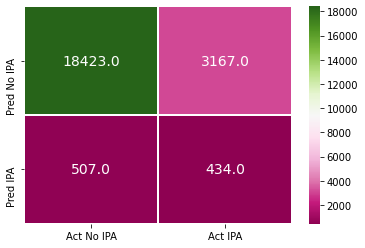

In [70]:
# metrics
metrics = MulticlassMetrics(predictionAndLabels)

accuracy = metrics.recall()
    
recall_ipa = metrics.recall(1.0)
precision_ipa = metrics.precision(1.0)

recall_noipa = metrics.recall(0.0)
precision_noipa = metrics.precision(0.0)


print("Accuracy = %s" % accuracy)
print("Recall of IPA = %s" % recall_ipa)
print("Precision of IPA = %s" % precision_ipa)
print("Recall of noIPA = %s" % recall_noipa)
print("Precision of noIPA = %s" % precision_noipa)

cm = metrics.confusionMatrix()

ax = sns.heatmap(cm.values.reshape(2,2), linewidth=0.5, annot=True, fmt='', annot_kws={"size": 14}, cmap='PiYG', xticklabels=["Act No IPA", "Act IPA"], yticklabels=["Pred No IPA", "Pred IPA"])
plt.show()

Proviamo ora con il Decision Tree se otteniamo migliori risultati

In [72]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel

In [73]:
# Train a DecisionTree model.
model = DecisionTree.trainClassifier(train_rdd, numClasses=2, categoricalFeaturesInfo={}, impurity='gini', maxDepth=5, maxBins=32)

# Evaluate model on test instances and compute test error
test_predictions_rdd = model.predict(test_rdd.map(lambda x: x.features))

# predict
#predictionAndLabels = test_rdd.map(lambda lp: (model.predict(lp.features), lp.label))
#test_predictions_rdd = model.predict(test_rdd.map(lambda x: x.features))

#predictionAndLabels = test_predictions_rdd.zip(test_labels_rdd)

In [76]:
# compute accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(test_labels_rdd.collect(),test_predictions_rdd.collect()))

Accuracy: 0.8829612533842262


In [77]:
from sklearn.metrics import confusion_matrix
# plot confusion matrix
cm = confusion_matrix(test_labels_rdd.collect(),test_predictions_rdd.collect())

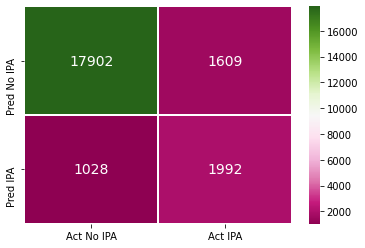

In [81]:
ax = sns.heatmap(cm.transpose(), linewidth=0.5, annot=True, fmt='', annot_kws={"size": 14}, cmap='PiYG', xticklabels=["Act No IPA", "Act IPA"], yticklabels=["Pred No IPA", "Pred IPA"])
plt.show()

In [82]:
from sklearn.metrics import classification_report

print(classification_report(test_labels_rdd.collect(),test_predictions_rdd.collect(), target_names=['No IPA', 'IPA']))

              precision    recall  f1-score   support

      No IPA       0.92      0.95      0.93     18930
         IPA       0.66      0.55      0.60      3601

    accuracy                           0.88     22531
   macro avg       0.79      0.75      0.77     22531
weighted avg       0.88      0.88      0.88     22531



In [83]:
print(model.toDebugString())

DecisionTreeModel classifier of depth 5 with 15 nodes
  If (feature 3 <= 48.315)
   Predict: 0.0
  Else (feature 3 > 48.315)
   If (feature 4 <= 13.735)
    If (feature 2 <= 7.865)
     If (feature 1 <= 1.0554999999999999)
      Predict: 0.0
     Else (feature 1 > 1.0554999999999999)
      If (feature 2 <= 7.505)
       Predict: 1.0
      Else (feature 2 > 7.505)
       Predict: 0.0
    Else (feature 2 > 7.865)
     If (feature 2 <= 8.975000000000001)
      If (feature 6 <= 80.5)
       Predict: 0.0
      Else (feature 6 > 80.5)
       Predict: 1.0
     Else (feature 2 > 8.975000000000001)
      Predict: 0.0
   Else (feature 4 > 13.735)
    Predict: 0.0



Il Decision Tree sembra funzionare meglio con la classe IPA: le features che sono state più usate per la costruzione dell'albero risultano essere:
- OG
- Size(L)
- IBU

Addesso proviamo Gradient boost classifier e Random Forest

In [84]:
from pyspark.mllib.tree import GradientBoostedTrees

Accuracy: 0.8832275531489947


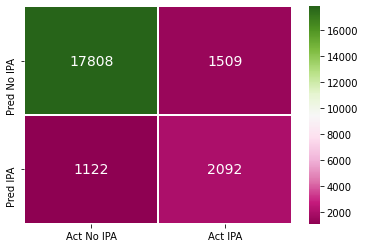

              precision    recall  f1-score   support

      No IPA       0.92      0.94      0.93     18930
         IPA       0.65      0.58      0.61      3601

    accuracy                           0.88     22531
   macro avg       0.79      0.76      0.77     22531
weighted avg       0.88      0.88      0.88     22531



In [85]:
# train 
model = GradientBoostedTrees.trainClassifier(train_rdd, categoricalFeaturesInfo={}, numIterations=10)

# predict
test_predictions_rdd = model.predict(test_rdd.map(lambda lp: lp.features))

# compute metrics
print("Accuracy:", accuracy_score(test_labels_rdd.collect(),test_predictions_rdd.collect()))

cm = confusion_matrix(test_labels_rdd.collect(),test_predictions_rdd.collect())

ax = sns.heatmap(cm.transpose(), linewidth=0.5, annot=True, fmt='', annot_kws={"size": 14}, cmap='PiYG', xticklabels=["Act No IPA", "Act IPA"], yticklabels=["Pred No IPA", "Pred IPA"])
plt.show()

print(classification_report(test_labels_rdd.collect(),test_predictions_rdd.collect(), target_names=['No IPA', 'IPA']))

Random forest

Accuracy: 0.8851360347965026


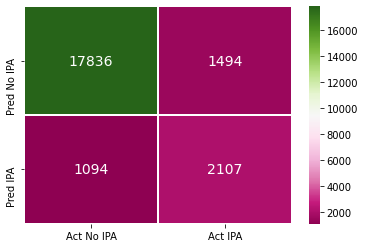

              precision    recall  f1-score   support

      No IPA       0.92      0.94      0.93     18930
         IPA       0.66      0.59      0.62      3601

    accuracy                           0.89     22531
   macro avg       0.79      0.76      0.78     22531
weighted avg       0.88      0.89      0.88     22531



In [87]:
from pyspark.mllib.tree import RandomForest, RandomForestModel 
from pyspark.mllib.util import MLUtils

model = RandomForest.trainClassifier(train_rdd, 
                                     numClasses=2, 
                                     categoricalFeaturesInfo={},
                                     numTrees=16, 
                                     featureSubsetStrategy="auto", 
                                     impurity='gini', 
                                     maxDepth=9, 
                                     maxBins=32)

# Evaluate model on test instances and compute test error
test_predictions_rdd = model.predict(test_rdd.map(lambda x: x.features))

# compute metrics
print("Accuracy:", accuracy_score(test_labels_rdd.collect(),test_predictions_rdd.collect()))

cm = confusion_matrix(test_labels_rdd.collect(),test_predictions_rdd.collect())

ax = sns.heatmap(cm.transpose(), linewidth=0.5, annot=True, fmt='', annot_kws={"size": 14}, cmap='PiYG', xticklabels=["Act No IPA", "Act IPA"], yticklabels=["Pred No IPA", "Pred IPA"])
plt.show()

print(classification_report(test_labels_rdd.collect(),test_predictions_rdd.collect(), target_names=['No IPA', 'IPA']))

Proviamo ora a trainare l'algoritmo su una dataset più bilanciato.

In [88]:
ipa_rdd = train_rdd.filter(lambda x: x.label == 1)

In [89]:
ipa_rdd.count()

8339

In [90]:
noIpa_rdd = train_rdd.filter(lambda x: x.label == 0)

In [91]:
noIpa_rdd.count()

42991

In [92]:
noIpa_rdd = noIpa_rdd.sample(withReplacement=False, fraction=0.2)

In [93]:
noIpa_rdd.count()

8620

In [94]:
trainb_rdd = ipa_rdd.union(noIpa_rdd)

In [95]:
pd.DataFrame(
    data=[count_labels(trainb_rdd), count_labels(test_rdd)],
    index=["train_bil", "test"]
)

,No IPA,IPA
train_bil,8620,8339
test,18930,3601


Accuracy: 0.828236651724291


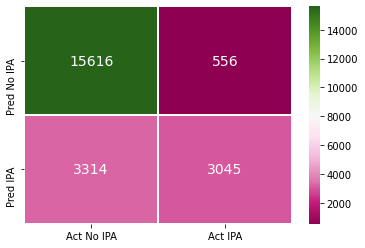

              precision    recall  f1-score   support

      No IPA       0.97      0.82      0.89     18930
         IPA       0.48      0.85      0.61      3601

    accuracy                           0.83     22531
   macro avg       0.72      0.84      0.75     22531
weighted avg       0.89      0.83      0.85     22531



In [96]:
model = RandomForest.trainClassifier(trainb_rdd, 
                                     numClasses=2, 
                                     categoricalFeaturesInfo={},
                                     numTrees=16, 
                                     featureSubsetStrategy="auto", 
                                     impurity='gini', 
                                     maxDepth=9, 
                                     maxBins=32)

# Evaluate model on test instances and compute test error
test_predictions_rdd = model.predict(test_rdd.map(lambda x: x.features))

# compute metrics
print("Accuracy:", accuracy_score(test_labels_rdd.collect(),test_predictions_rdd.collect()))

cm = confusion_matrix(test_labels_rdd.collect(),test_predictions_rdd.collect())

ax = sns.heatmap(cm.transpose(), linewidth=0.5, annot=True, fmt='', annot_kws={"size": 14}, cmap='PiYG', xticklabels=["Act No IPA", "Act IPA"], yticklabels=["Pred No IPA", "Pred IPA"])
plt.show()

print(classification_report(test_labels_rdd.collect(),test_predictions_rdd.collect(), target_names=['No IPA', 'IPA']))

Accuracy: 0.8266388531356798


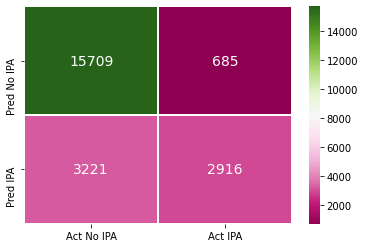

              precision    recall  f1-score   support

      No IPA       0.96      0.83      0.89     18930
         IPA       0.48      0.81      0.60      3601

    accuracy                           0.83     22531
   macro avg       0.72      0.82      0.74     22531
weighted avg       0.88      0.83      0.84     22531



In [97]:
# train 
model = GradientBoostedTrees.trainClassifier(trainb_rdd, categoricalFeaturesInfo={}, numIterations=10)

# predict
test_predictions_rdd = model.predict(test_rdd.map(lambda lp: lp.features))

# compute metrics
print("Accuracy:", accuracy_score(test_labels_rdd.collect(),test_predictions_rdd.collect()))

cm = confusion_matrix(test_labels_rdd.collect(),test_predictions_rdd.collect())

ax = sns.heatmap(cm.transpose(), linewidth=0.5, annot=True, fmt='', annot_kws={"size": 14}, cmap='PiYG', xticklabels=["Act No IPA", "Act IPA"], yticklabels=["Pred No IPA", "Pred IPA"])
plt.show()

print(classification_report(test_labels_rdd.collect(),test_predictions_rdd.collect(), target_names=['No IPA', 'IPA']))

Proviamo infine un algoritmo di clustering per vedere se le due classi sono raggruppate insieme o meno.

In [372]:
from pyspark.mllib.clustering import KMeans

In [383]:
# select the features
rdd_feature = trainb_rdd.map(lambda t: t.features)

# train
model = KMeans.train(rdd_feature, k=2, runs=10, initializationMode="random")

In [384]:
# assign to the clusters
cluster_data = trainb_rdd.map(lambda x: (x.label, model.predict(x.features)))

In [385]:
tn = cluster_data.filter(lambda x: x[0] == 0 and x[1] == 0).count()
tp = cluster_data.filter(lambda x: x[0] == 1 and x[1] == 1).count()
fp = cluster_data.filter(lambda x: x[0] == 0 and x[1] == 1).count()
fn = cluster_data.filter(lambda x: x[0] == 1 and x[1] == 0).count()

In [386]:
print("TN: {}, TP: {}, FP: {}, FN: {}".format(tn, tp, fp, fn))
print("Accuracy: {}".format((tp + tn)/(tp + tn + fp + fn)))
print("Precision: {}".format(tp/(tp + fp)))
print("Recall: {}".format(tp/(tp + fn)))

TN: 4350, TP: 4457, FP: 4251, FN: 3912
Accuracy: 0.5189746611667648
Precision: 0.5118282039503904
Recall: 0.5325606404588362
